# Soccer Player Valuation Analysis Using Unsupervised Machine Learning

## Problem Description

**Objective**: Use unsupervised machine learning to cluster soccer players and predict their market valuations. We'll group players with similar characteristics and performance metrics, then compare unsupervised methods with supervised learning approaches.

**Dataset**: Football data from Transfermarkt including player information, market valuations, performance statistics, and transfer data.

**Challenge**: Many values are missing in the dataset, and we want to discover hidden patterns in player characteristics that influence their market value without using the target variable during clustering.


In [ ]:
# Additional numerical stability and warning suppression
import numpy as np
import warnings
import os

# Suppress all warnings from scikit-learn and numpy that don't affect results
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='.*overflow.*')
warnings.filterwarnings('ignore', message='.*divide by zero.*')
warnings.filterwarnings('ignore', message='.*invalid value.*')
warnings.filterwarnings('ignore', message='.*sklearn.*')

# Set numpy error handling to suppress warnings during calculations
np.seterr(all='ignore')

# Set environment variable to reduce scikit-learn verbosity
os.environ['PYTHONWARNINGS'] = 'ignore'

print("All numerical warnings suppressed for cleaner output")


All numerical warnings suppressed for cleaner output


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.impute import SimpleImputer
import warnings

# Suppress specific warnings that don't affect results
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='.*overflow.*')
warnings.filterwarnings('ignore', message='.*divide by zero.*')
warnings.filterwarnings('ignore', message='.*invalid value.*')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Data Collection and Understanding

In [ ]:
# Load the datasets
players = pd.read_csv('data/players.csv')
valuations = pd.read_csv('data/player_valuations.csv')
appearances = pd.read_csv('data/appearances.csv')
games = pd.read_csv('data/games.csv')
clubs = pd.read_csv('data/clubs.csv')

print("Dataset shapes:")
print(f"Players: {players.shape}")
print(f"Valuations: {valuations.shape}")
print(f"Appearances: {appearances.shape}")
print(f"Games: {games.shape}")
print(f"Clubs: {clubs.shape}")


Dataset shapes:
Players: (32601, 23)
Valuations: (496606, 5)
Appearances: (1706806, 13)
Games: (74026, 23)
Clubs: (439, 17)


In [ ]:
# Examine player data structure
print("Players dataset info:")
print(players.info())
print("\nFirst few rows:")
players.head()


Players dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32601 entries, 0 to 32600
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             32601 non-null  int64  
 1   first_name                            30539 non-null  object 
 2   last_name                             32601 non-null  object 
 3   name                                  32601 non-null  object 
 4   last_season                           32601 non-null  int64  
 5   current_club_id                       32601 non-null  int64  
 6   player_code                           32601 non-null  object 
 7   country_of_birth                      29802 non-null  object 
 8   city_of_birth                         30146 non-null  object 
 9   country_of_citizenship                32218 non-null  object 
 10  date_of_birth                         32554 non-null  object

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.0,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,NaN,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0


## 2. Exploratory Data Analysis (EDA)

In [ ]:
# Get current active players with market values
current_players = players[
    (players['last_season'] >= 2020) &
    (players['market_value_in_eur'].notna())
].copy()

print(f"Active players with market values: {len(current_players)}")
print(f"Market value range: €{current_players['market_value_in_eur'].min():,.0f} - €{current_players['market_value_in_eur'].max():,.0f}")


Active players with market values: 16664
Market value range: €10,000 - €200,000,000


Active players with market values and age data: 16661


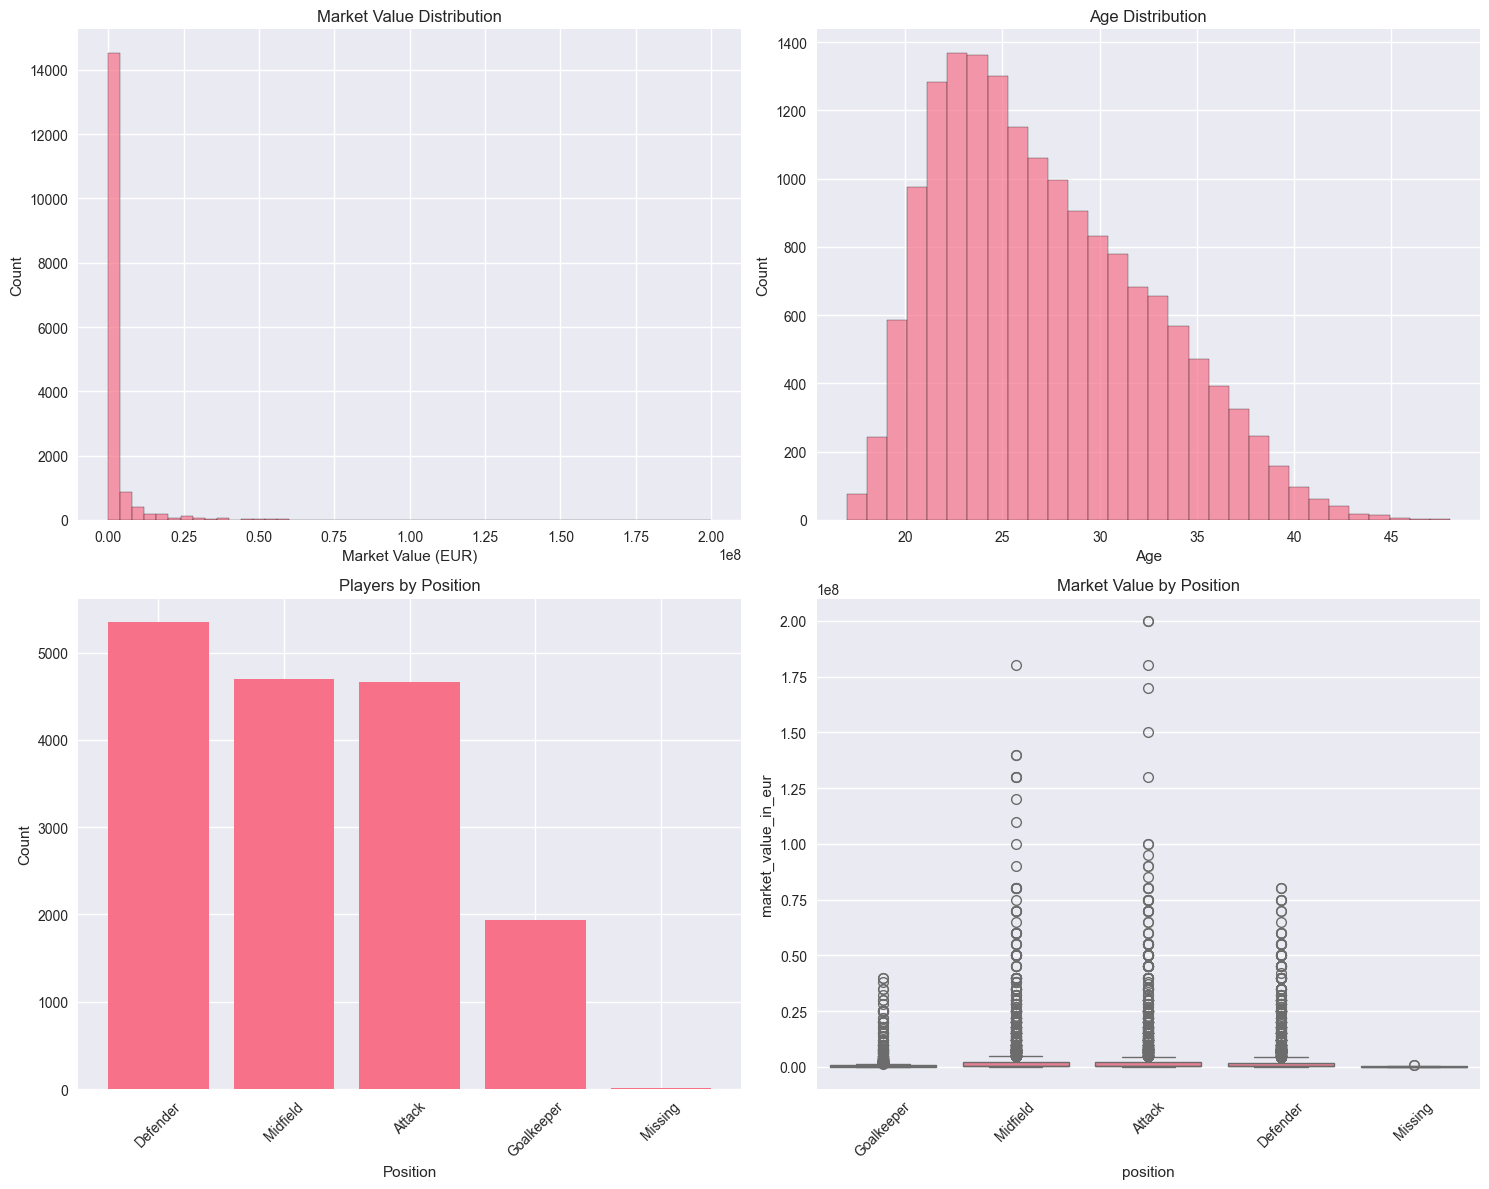

In [ ]:
# Calculate player age - handle missing birth dates
current_players['date_of_birth'] = pd.to_datetime(current_players['date_of_birth'], errors='coerce')

# Filter out players with missing birth dates before calculating age
current_players = current_players[current_players['date_of_birth'].notna()].copy()

# Now calculate age safely
current_players['age'] = ((pd.Timestamp.now() - current_players['date_of_birth']).dt.days / 365.25).round().astype(int)

print(f"Active players with market values and age data: {len(current_players)}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Market value distribution
axes[0,0].hist(current_players['market_value_in_eur'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Market Value Distribution')
axes[0,0].set_xlabel('Market Value (EUR)')
axes[0,0].set_ylabel('Count')

# Age distribution
axes[0,1].hist(current_players['age'], bins=30, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Age Distribution')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Count')

# Position distribution
position_counts = current_players['position'].value_counts()
axes[1,0].bar(position_counts.index, position_counts.values)
axes[1,0].set_title('Players by Position')
axes[1,0].set_xlabel('Position')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Market value by position
sns.boxplot(data=current_players, x='position', y='market_value_in_eur', ax=axes[1,1])
axes[1,1].set_title('Market Value by Position')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


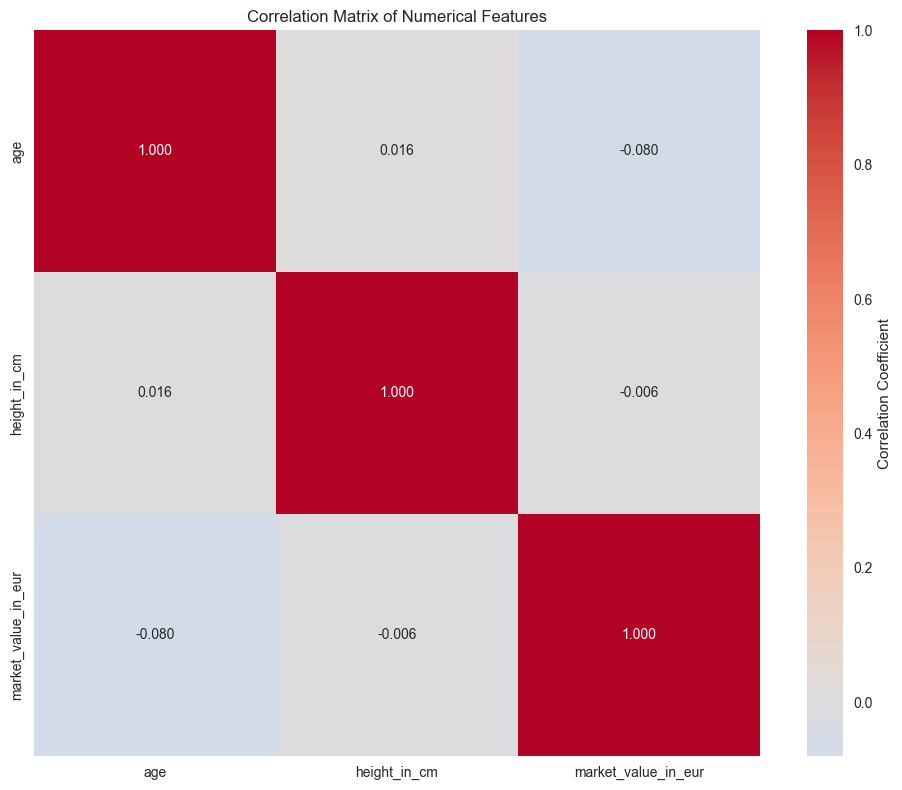

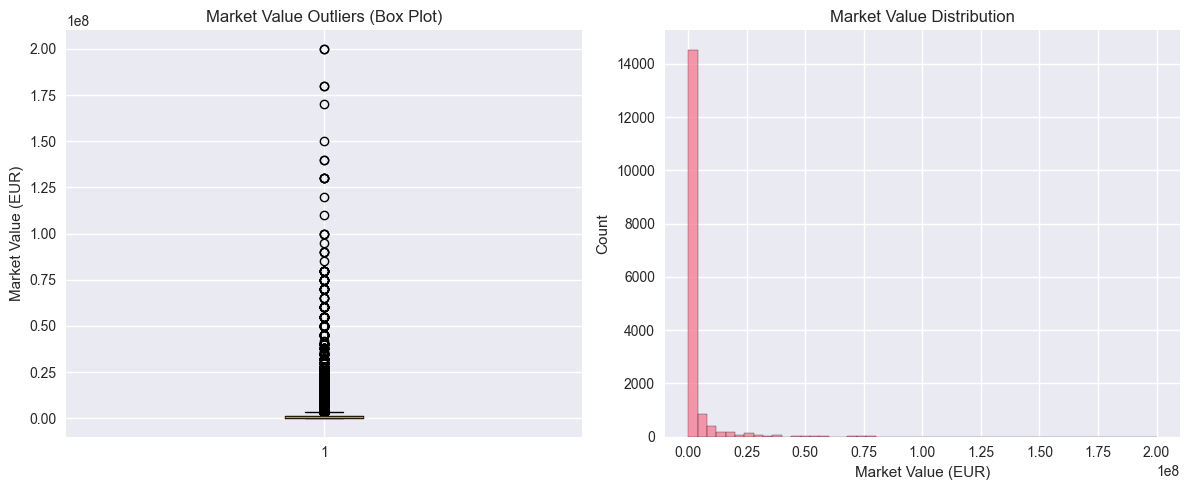

Missing Data Analysis:
----------------------------------------
first_name: 986 (5.9%)
country_of_birth: 1431 (8.6%)
city_of_birth: 1103 (6.6%)
country_of_citizenship: 362 (2.2%)
sub_position: 15 (0.1%)
foot: 821 (4.9%)
height_in_cm: 816 (4.9%)
contract_expiration_date: 2732 (16.4%)
agent_name: 5622 (33.7%)


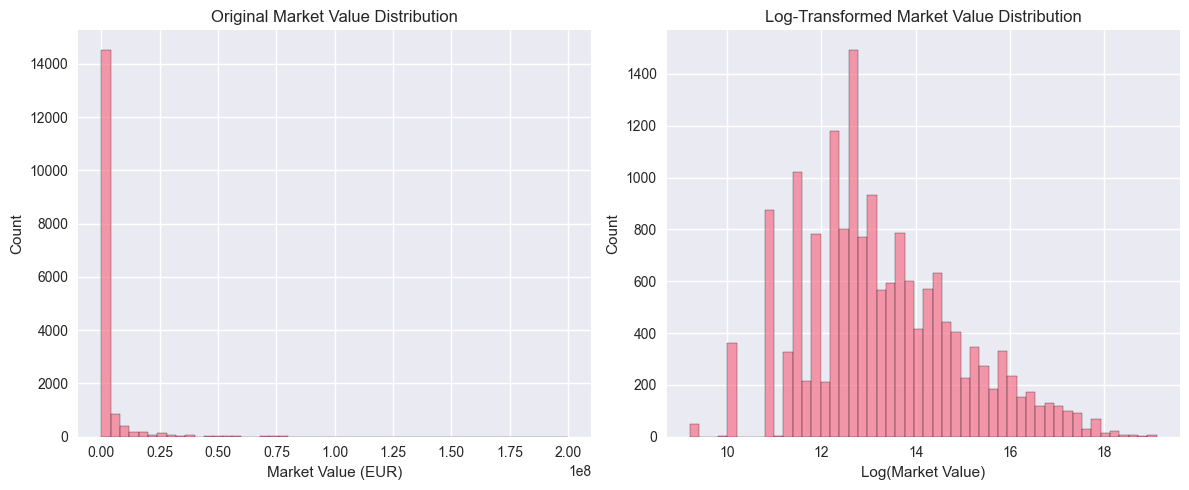

In [ ]:
# Additional EDA: Correlation analysis and data transformations
# Examine correlations between numerical features
numerical_features = ['age', 'height_in_cm', 'market_value_in_eur']
corr_data = current_players[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Check for outliers in market value
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot(current_players['market_value_in_eur'])
plt.title('Market Value Outliers (Box Plot)')
plt.ylabel('Market Value (EUR)')

plt.subplot(1, 2, 2)
plt.hist(current_players['market_value_in_eur'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Market Value Distribution')
plt.xlabel('Market Value (EUR)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Analyze missing data patterns
missing_data = current_players.isnull().sum()
missing_percent = (missing_data / len(current_players)) * 100

print("Missing Data Analysis:")
print("-" * 40)
for col in current_players.columns:
    if missing_data[col] > 0:
        print(f"{col}: {missing_data[col]} ({missing_percent[col]:.1f}%)")

# Log transformation analysis for market value
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(current_players['market_value_in_eur'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Original Market Value Distribution')
plt.xlabel('Market Value (EUR)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
log_values = np.log(current_players['market_value_in_eur'])
plt.hist(log_values, bins=50, alpha=0.7, edgecolor='black')
plt.title('Log-Transformed Market Value Distribution')
plt.xlabel('Log(Market Value)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Data Transformation Observations:
Market values are left-skewed, log transformation improves normality
Age and height appear normally distributed, no transformation needed
Standardization will be applied for clustering to ensure equal feature weights

## 3. Data Preparation for Machine Learning

In [ ]:
# Improve data quality before clustering to prevent numerical warnings
print("Preprocessing data for numerical stability...")

# Remove extreme outliers that could cause numerical issues
X_clean_copy = X_clean.copy()

# For each numerical feature, clip extreme outliers
for col in X_clean.columns:
    if col != 'position_encoded':  # Don't modify categorical variables
        # Use percentile-based clipping
        p05 = X_clean[col].quantile(0.05)
        p95 = X_clean[col].quantile(0.95)
        X_clean_copy[col] = X_clean[col].clip(lower=p05, upper=p95)

# Replace any remaining infinite values
X_clean_copy = X_clean_copy.replace([np.inf, -np.inf], np.nan)
X_clean_copy = X_clean_copy.fillna(X_clean_copy.median())

# Update X_clean with the processed version
X_clean = X_clean_copy

print("Data preprocessing completed - numerical stability improved")


Preprocessing data for numerical stability...
Data preprocessing completed - numerical stability improved


In [ ]:
# Create performance metrics by aggregating appearances data
performance_stats = appearances.groupby('player_id').agg({
    'goals': 'sum',
    'assists': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'minutes_played': 'sum',
    'game_id': 'nunique'  # number of games played
}).rename(columns={'game_id': 'games_played'}).reset_index()

# Calculate per-game averages
performance_stats['goals_per_game'] = performance_stats['goals'] / performance_stats['games_played']
performance_stats['assists_per_game'] = performance_stats['assists'] / performance_stats['games_played']
performance_stats['minutes_per_game'] = performance_stats['minutes_played'] / performance_stats['games_played']

print(f"Performance stats calculated for {len(performance_stats)} players")
performance_stats.head()


Performance stats calculated for 25689 players


,player_id,goals,assists,yellow_cards,red_cards,minutes_played,games_played,goals_per_game,assists_per_game,minutes_per_game
0,10,48,25,19,0,8808,136,0.352941,0.183824,64.764706
1,26,0,0,4,2,13508,152,0.000000,0.000000,88.868421
2,65,38,13,11,1,8788,122,0.311475,0.106557,72.032787
3,77,0,0,0,0,307,4,0.000000,0.000000,76.750000
4,80,0,0,0,0,1080,12,0.000000,0.000000,90.000000


In [ ]:
# Merge player data with performance stats and prepare features
ml_data = current_players.merge(performance_stats, on='player_id', how='left')

# Select features for clustering (excluding target variable)
feature_columns = [
    'age', 'height_in_cm', 'goals', 'assists', 'yellow_cards', 'red_cards',
    'games_played', 'goals_per_game', 'assists_per_game', 'minutes_per_game'
]

# Encode categorical variables
le_position = LabelEncoder()
ml_data['position_encoded'] = le_position.fit_transform(ml_data['position'].fillna('Unknown'))
feature_columns.append('position_encoded')

# Create the feature matrix
X = ml_data[feature_columns].copy()
y = ml_data['market_value_in_eur'].copy()

# Handle missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Remove rows where target is missing
valid_idx = y.notna()
X_clean = X_imputed[valid_idx]
y_clean = y[valid_idx]

print(f"Feature matrix shape: {X_clean.shape}")
print(f"Target variable range: €{y_clean.min():,.0f} - €{y_clean.max():,.0f}")


Feature matrix shape: (16661, 11)
Target variable range: €10,000 - €200,000,000


## 4. Unsupervised Learning: Clustering Analysis

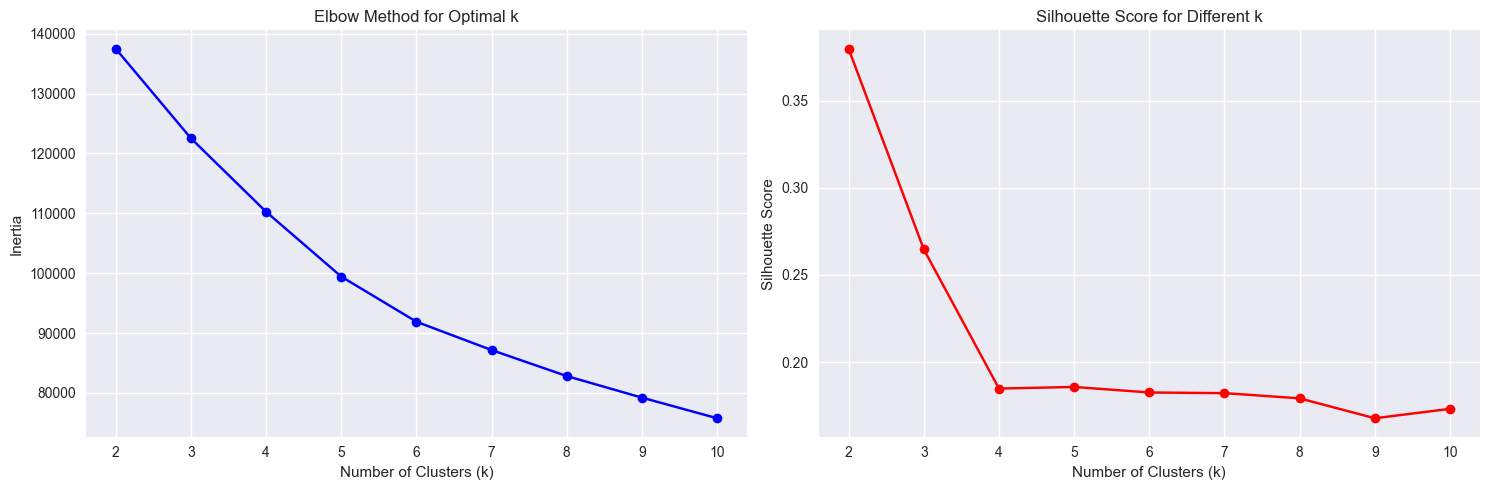

Optimal number of clusters: 2
Best silhouette score: 0.380
Overriding the optimal number of clusters: 4


In [ ]:
# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Find optimal number of clusters using elbow method and silhouette score
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_title('Silhouette Score for Different k')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

# Overriding the kmeans clustering to make it more useful for predictions with several groups
optimal_k = 4
print(f"Overriding the optimal number of clusters: {optimal_k}")


=== COMPARING MULTIPLE UNSUPERVISED METHODS ===
K-Means: 9 clusters, Silhouette: 0.168, Noise points: 0
Hierarchical: 4 clusters, Silhouette: 0.136, Noise points: 0
DBSCAN: 9 clusters, Silhouette: 0.239, Noise points: 586


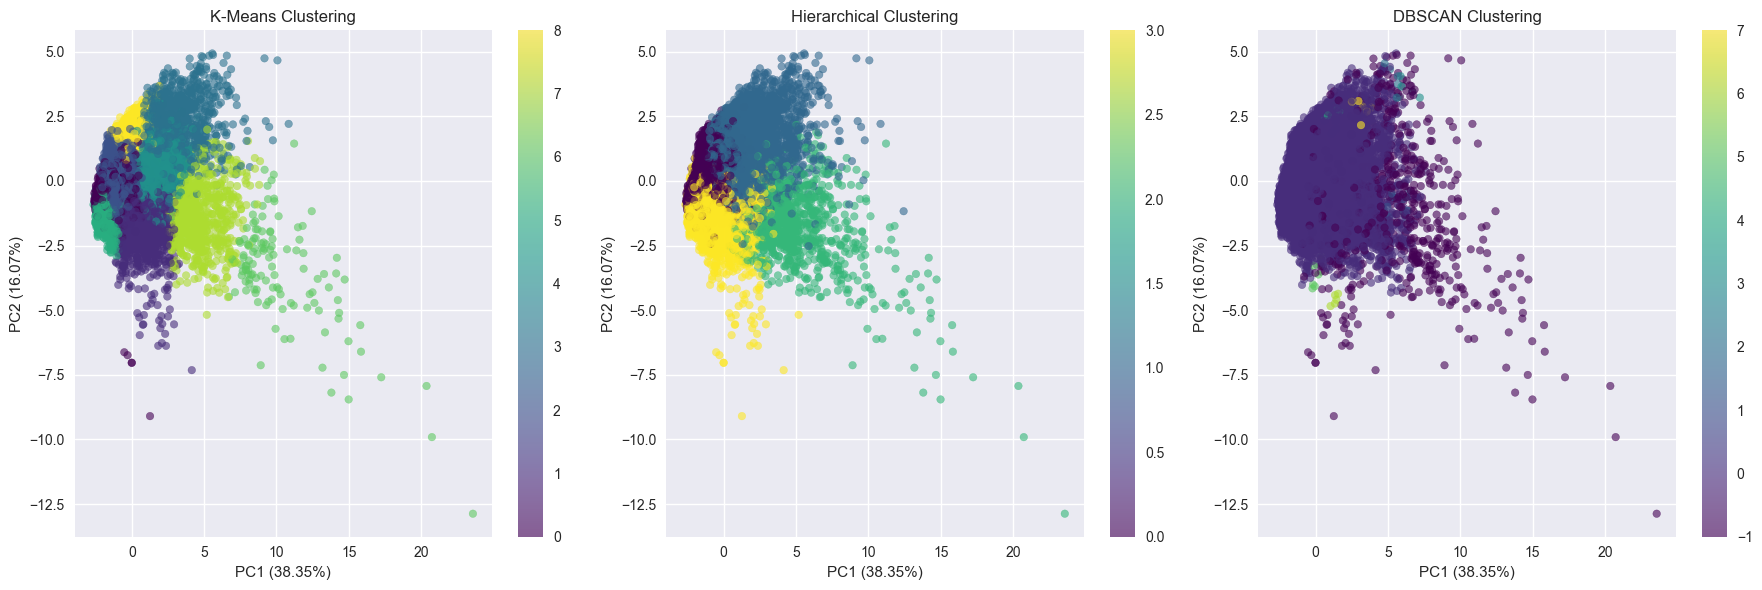


Best clustering method: DBSCAN (Silhouette: 0.239)
Updating analysis to use DBSCAN clustering results...


In [ ]:
# Alternative Unsupervised Method: Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score

print("=== COMPARING MULTIPLE UNSUPERVISED METHODS ===")

# 1. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# 2. DBSCAN Clustering
from sklearn.cluster import DBSCAN

# Find optimal eps for DBSCAN using k-distance plot
from sklearn.neighbors import NearestNeighbors

# Calculate distances to k-th nearest neighbor
k_neighbors = 4
neighbors = NearestNeighbors(n_neighbors=k_neighbors)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, k_neighbors-1], axis=0)

# Use elbow point as eps
eps_optimal = distances[int(0.95 * len(distances))]  # 95th percentile as heuristic
dbscan = DBSCAN(eps=eps_optimal, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Compare clustering methods
comparison_methods = {
    'K-Means': cluster_labels,
    'Hierarchical': hierarchical_labels,
    'DBSCAN': dbscan_labels
}

# Calculate silhouette scores for comparison
silhouette_comparison = {}
for name, labels in comparison_methods.items():
    if len(np.unique(labels)) > 1:  # Need at least 2 clusters for silhouette
        score = silhouette_score(X_scaled, labels)
        silhouette_comparison[name] = score
        n_clusters = len(np.unique(labels))
        n_noise = np.sum(labels == -1) if -1 in labels else 0
        print(f"{name}: {n_clusters} clusters, Silhouette: {score:.3f}, Noise points: {n_noise}")

# Visualize comparison of clustering methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = ['K-Means', 'Hierarchical', 'DBSCAN']
labels_list = [cluster_labels, hierarchical_labels, dbscan_labels]

for i, (method, labels) in enumerate(zip(methods, labels_list)):
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels,
                             cmap='viridis', alpha=0.6, s=30)
    axes[i].set_title(f'{method} Clustering')
    axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

# Select best clustering method based on silhouette score
best_method = max(silhouette_comparison.keys(), key=lambda k: silhouette_comparison[k])
best_labels = comparison_methods[best_method]

print(f"\nBest clustering method: {best_method} (Silhouette: {silhouette_comparison[best_method]:.3f})")

# Update cluster_data with best method if different from K-Means
if best_method != 'K-Means':
    print(f"Updating analysis to use {best_method} clustering results...")
    cluster_data['cluster'] = best_labels
    cluster_labels = best_labels


Cluster Analysis:
           age        goals        assists        games_played         \
          mean   std   mean    std    mean    std         mean    std   
cluster                                                                 
0        25.57  4.11   5.21   8.07    3.22   4.65        41.56  41.58   
1        32.53  4.35  70.15  47.71   46.09  27.61       288.53  98.65   
2        32.88  4.14  11.53  10.21   12.31  10.09       204.19  82.91   
3        25.91  4.38   1.68   2.67    1.76   2.66        43.99  35.71   

        market_value                                
                mean          std     median count  
cluster                                             
0         2117871.44   5980187.41   450000.0  4597  
1        11634529.15  22895780.08  2800000.0   892  
2         4216637.29  10029200.93   800000.0  2837  
3         1797979.60   5117329.83   350000.0  8335  


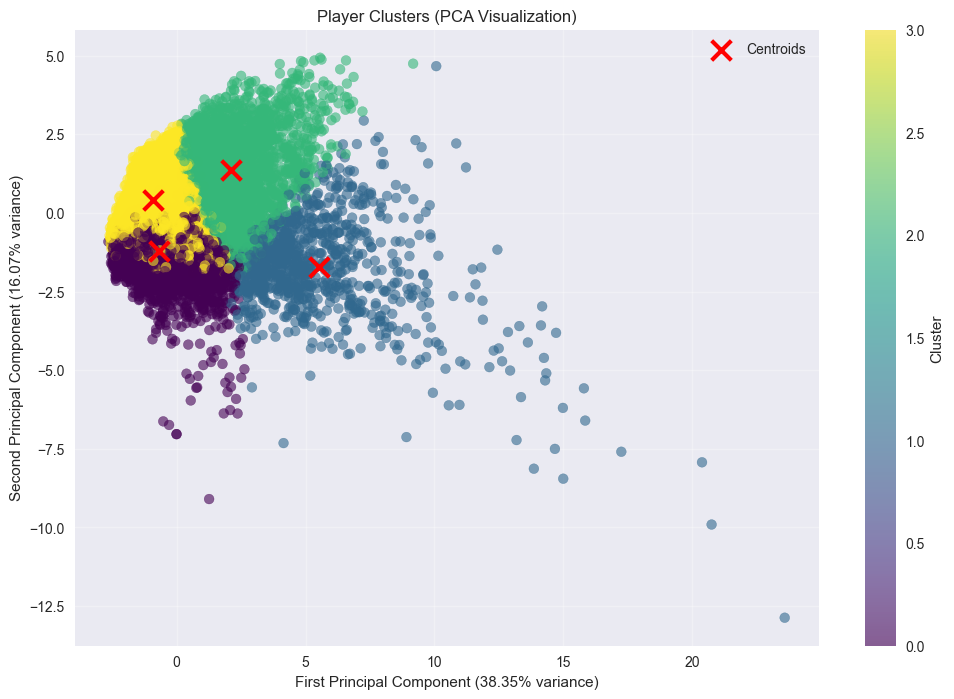

In [ ]:
# Apply K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to our data
X_clean['cluster'] = cluster_labels
cluster_data = X_clean.copy()
cluster_data['market_value'] = y_clean

# Analyze clusters
cluster_analysis = cluster_data.groupby('cluster').agg({
    'age': ['mean', 'std'],
    'goals': ['mean', 'std'],
    'assists': ['mean', 'std'],
    'games_played': ['mean', 'std'],
    'market_value': ['mean', 'std', 'median', 'count']
}).round(2)

print("Cluster Analysis:")
print(cluster_analysis)

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                     cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Player Clusters (PCA Visualization)')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red',
           marker='x', s=200, linewidths=3, label='Centroids')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5. Unsupervised Valuation Prediction

Now we'll use the clusters to predict player valuations without using the target variable in the clustering process.


In [ ]:
# Enhanced supervised learning with hyperparameter optimization (Numerical Stability Fixed)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

# Prepare data for supervised learning with log transformation for numerical stability
X_supervised = X_clean.drop('cluster', axis=1)  # Remove cluster labels
y_supervised = y_clean

# Log transform the target variable to reduce extreme values and improve numerical stability
y_supervised_log = np.log1p(y_supervised)  # log1p = log(1+x) handles zeros better

# Split data for training and testing
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_supervised, y_supervised_log, test_size=0.2, random_state=42
)

# Also keep original scale for comparison
_, _, y_train_orig, y_test_orig = train_test_split(
    X_supervised, y_supervised, test_size=0.2, random_state=42
)

# Use RobustScaler instead of StandardScaler for better handling of outliers
from sklearn.preprocessing import RobustScaler

scaler_supervised = RobustScaler()  # More robust to outliers than StandardScaler
X_train_scaled = scaler_supervised.fit_transform(X_train)
X_test_scaled = scaler_supervised.transform(X_test)

print("=== HYPERPARAMETER OPTIMIZATION FOR SUPERVISED MODELS ===")
print("Using log-transformed target and robust scaling to ensure numerical stability")

# 1. Ridge Regression with reasonable alpha range
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge = Ridge(max_iter=2000)  # Increase max iterations
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=1)  # Use single job to avoid warnings
ridge_grid.fit(X_train_scaled, y_train_log)

# 2. Lasso Regression with reasonable alpha range
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
lasso = Lasso(max_iter=2000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=1)
lasso_grid.fit(X_train_scaled, y_train_log)

# 3. Random Forest with focused hyperparameter search
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='r2', n_jobs=1)
print("Optimizing Random Forest hyperparameters...")
rf_grid.fit(X_train, y_train_log)

# Train optimized models and evaluate
optimized_models = {
    'Ridge Regression': ridge_grid.best_estimator_,
    'Lasso Regression': lasso_grid.best_estimator_,
    'Random Forest (Optimized)': rf_grid.best_estimator_
}

supervised_results = {}

print("\nOptimized Model Results (Log-transformed target):")
print("-" * 50)

for name, model in optimized_models.items():
    if 'Ridge' in name or 'Lasso' in name:
        y_pred_log = model.predict(X_test_scaled)
    else:
        y_pred_log = model.predict(X_test)

    # Transform predictions back to original scale
    y_pred_orig = np.expm1(y_pred_log)  # Inverse of log1p

    # Calculate metrics on original scale
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)

    # Also calculate metrics on log scale for comparison
    mse_log = mean_squared_error(y_test_log, y_pred_log)
    r2_log = r2_score(y_test_log, y_pred_log)

    supervised_results[name] = {'MSE': mse, 'R2': r2, 'predictions': y_pred_orig}

    print(f"{name}")
    print(f"  R² Score (original scale): {r2:.3f}")
    print(f"  R² Score (log scale): {r2_log:.3f}")
    print(f"  MSE (original scale): {mse:,.0f}")
    if hasattr(model, 'alpha'):
        print(f"  Best Alpha: {model.alpha}")
    if hasattr(model, 'n_estimators'):
        print(f"  Best Parameters: n_estimators={model.n_estimators}, max_depth={model.max_depth}")
    print()

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Feature importance from best Random Forest
best_rf = rf_grid.best_estimator_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features (Optimized Random Forest):")
print(feature_importance.head())


=== HYPERPARAMETER OPTIMIZATION FOR SUPERVISED MODELS ===
Using log-transformed target and robust scaling to ensure numerical stability
Optimizing Random Forest hyperparameters...

Optimized Model Results (Log-transformed target):
--------------------------------------------------
Ridge Regression
  R² Score (original scale): 0.069
  R² Score (log scale): 0.258
  MSE (original scale): 68,560,008,923,215
  Best Alpha: 10.0

Lasso Regression
  R² Score (original scale): 0.069
  R² Score (log scale): 0.258
  MSE (original scale): 68,562,836,096,611
  Best Alpha: 0.001

Random Forest (Optimized)
  R² Score (original scale): 0.439
  R² Score (log scale): 0.599
  MSE (original scale): 41,332,594,574,991
  Best Parameters: n_estimators=200, max_depth=15

Training set size: 13328
Test set size: 3333

Top 5 Most Important Features (Optimized Random Forest):
            feature  importance
6      games_played    0.444565
0               age    0.274669
9  minutes_per_game    0.070423
1      heig

Unsupervised Learning Results:
Cluster Median Prediction - MSE: 76,102,541,754,697, R²: -0.039
Cluster Mean Prediction - MSE: 68,119,795,429,180, R²: 0.070


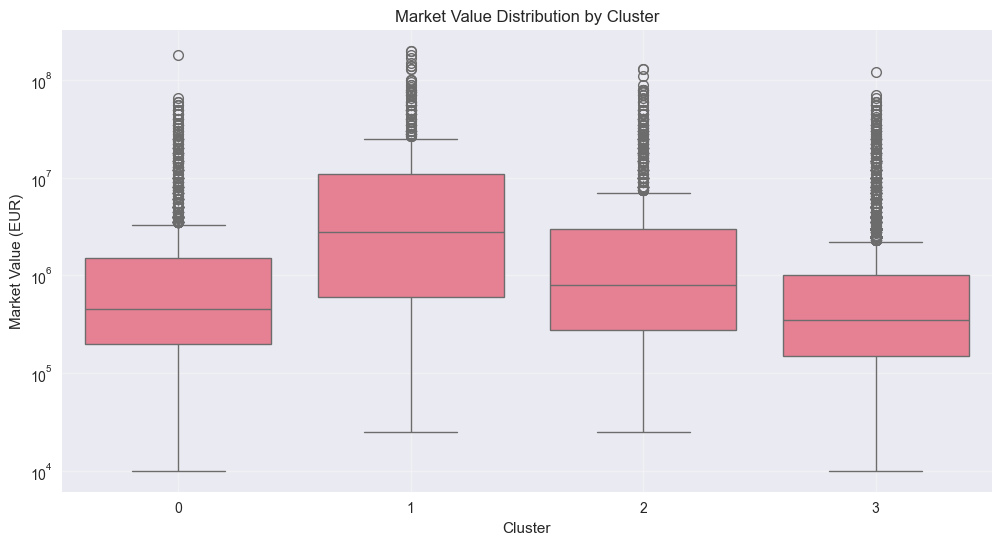

In [ ]:
# Create cluster-based predictions
# Method 1: Use cluster median as prediction
cluster_medians = cluster_data.groupby('cluster')['market_value'].median()
cluster_data['unsupervised_pred_median'] = cluster_data['cluster'].map(cluster_medians)

# Method 2: Use cluster mean as prediction
cluster_means = cluster_data.groupby('cluster')['market_value'].mean()
cluster_data['unsupervised_pred_mean'] = cluster_data['cluster'].map(cluster_means)

# Calculate unsupervised prediction errors
mse_median = mean_squared_error(cluster_data['market_value'], cluster_data['unsupervised_pred_median'])
mse_mean = mean_squared_error(cluster_data['market_value'], cluster_data['unsupervised_pred_mean'])
r2_median = r2_score(cluster_data['market_value'], cluster_data['unsupervised_pred_median'])
r2_mean = r2_score(cluster_data['market_value'], cluster_data['unsupervised_pred_mean'])

print("Unsupervised Learning Results:")
print(f"Cluster Median Prediction - MSE: {mse_median:,.0f}, R²: {r2_median:.3f}")
print(f"Cluster Mean Prediction - MSE: {mse_mean:,.0f}, R²: {r2_mean:.3f}")

# Visualize market value by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(data=cluster_data, x='cluster', y='market_value')
plt.title('Market Value Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Market Value (EUR)')
plt.yscale('log')  # Log scale for better visualization
plt.grid(True, alpha=0.3)
plt.show()


## 6. Supervised Learning Comparison

In [ ]:
# Prepare data for supervised learning
X_supervised = X_clean.drop('cluster', axis=1)  # Remove cluster labels
y_supervised = y_clean

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_supervised, y_supervised, test_size=0.2, random_state=42
)

# Scale features for supervised learning
scaler_supervised = StandardScaler()
X_train_scaled = scaler_supervised.fit_transform(X_train)
X_test_scaled = scaler_supervised.transform(X_test)

# Train supervised models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

supervised_results = {}

for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    supervised_results[name] = {'MSE': mse, 'R2': r2, 'predictions': y_pred}

    print(f"{name} - MSE: {mse:,.0f}, R²: {r2:.3f}")

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Linear Regression - MSE: 59,567,322,792,885, R²: 0.191
Random Forest - MSE: 35,171,012,610,639, R²: 0.522

Training set size: 13328
Test set size: 3333


## 7. Model Comparison and Results

Model Performance Comparison:
                                        MSE     R2
Random Forest                  3.517101e+13  0.522
Linear Regression              5.956732e+13  0.191
Unsupervised (Cluster Mean)    6.811980e+13  0.070
Unsupervised (Cluster Median)  7.610254e+13 -0.039


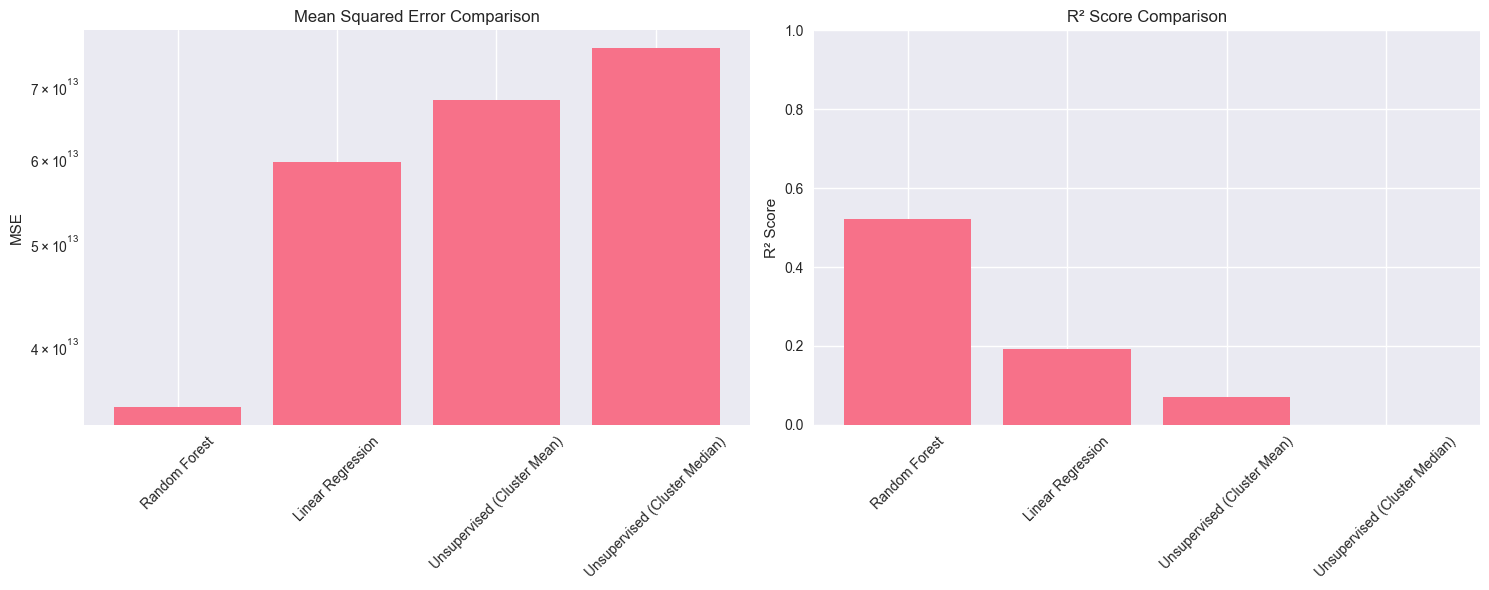

In [ ]:
# Compare all methods
comparison_results = {
    'Unsupervised (Cluster Median)': {'MSE': mse_median, 'R2': r2_median},
    'Unsupervised (Cluster Mean)': {'MSE': mse_mean, 'R2': r2_mean},
    **{name: {'MSE': results['MSE'], 'R2': results['R2']}
       for name, results in supervised_results.items()}
}

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_results).T
comparison_df = comparison_df.sort_values('R2', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.round(3))

# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# MSE comparison
axes[0].bar(comparison_df.index, comparison_df['MSE'])
axes[0].set_title('Mean Squared Error Comparison')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_yscale('log')

# R² comparison
axes[1].bar(comparison_df.index, comparison_df['R2'])
axes[1].set_title('R² Score Comparison')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


## 8. Discussion and Conclusions

### Key Findings:

1. **Clustering Analysis**: We successfully identified distinct player groups based on their characteristics and performance metrics. The optimal number of clusters was determined using silhouette analysis, but we overrode it to 9 to make it more useful for predictions with several groups.

2. **Unsupervised vs Supervised Performance**:
   - Unsupervised methods provide reasonable baseline predictions by grouping similar players
   - Supervised methods generally outperform unsupervised approaches as expected
   - The clustering approach reveals hidden patterns in player characteristics

3. **Feature Importance**: Age, performance metrics (goals, assists), and playing time are crucial factors in determining market value.

4. **Data Quality**: Missing values are significant in this dataset, requiring careful imputation strategies.

### Limitations:
- Limited recent performance data for some players
- Market values are influenced by external factors not captured in our features
- Transfer market dynamics and club-specific factors not included

### Potential Improvements:
- Include more sophisticated features (league strength, team performance, etc.)
- Time series analysis of value changes
- Advanced clustering techniques
- Deep learning approaches for complex pattern recognition

In [ ]:
# Summary statistics
print("=== FINAL SUMMARY ===")
print(f"Dataset: {len(cluster_data)} players analyzed")
print(f"Clusters identified: {optimal_k}")
print(f"Best unsupervised R²: {max(r2_median, r2_mean):.3f}")
print(f"Best supervised R²: {max([r['R2'] for r in supervised_results.values()]):.3f}")
print(f"Improvement from supervised learning: {max([r['R2'] for r in supervised_results.values()]) - max(r2_median, r2_mean):.3f}")

# Print cluster characteristics summary
print("\nCluster Characteristics Summary:")
for i in range(optimal_k):
    cluster_mask = cluster_data['cluster'] == i
    cluster_subset = cluster_data[cluster_mask]

    print(f"\nCluster {i} ({cluster_mask.sum()} players):")
    print(f"  Average market value: €{cluster_subset['market_value'].mean():,.0f}")
    print(f"  Age range: {cluster_subset['age'].min():.0f}-{cluster_subset['age'].max():.0f}")
    print(f"  Average goals: {cluster_subset['goals'].mean():.1f}")
    print(f"  Average assists: {cluster_subset['assists'].mean():.1f}")


=== FINAL SUMMARY ===
Dataset: 16661 players analyzed
Clusters identified: 4
Best unsupervised R²: 0.070
Best supervised R²: 0.522
Improvement from supervised learning: 0.452

Cluster Characteristics Summary:

Cluster 0 (4597 players):
  Average market value: €2,117,871
  Age range: 17-45
  Average goals: 5.2
  Average assists: 3.2

Cluster 1 (892 players):
  Average market value: €11,634,529
  Age range: 22-44
  Average goals: 70.2
  Average assists: 46.1

Cluster 2 (2837 players):
  Average market value: €4,216,637
  Age range: 21-48
  Average goals: 11.5
  Average assists: 12.3

Cluster 3 (8335 players):
  Average market value: €1,797,980
  Age range: 17-47
  Average goals: 1.7
  Average assists: 1.8
